In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import silhouette_score,adjusted_mutual_info_score,completeness_score, homogeneity_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans,DBSCAN, MiniBatchKMeans
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.manifold import TSNE
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.text import TSNEVisualizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import random
rs = 42 # random state
np.random.seed(rs)

In [4]:
def random_prediction(X_test, y_test):
    labels = list(set(y_test))
    prediction = [np.random.choice(labels) for _ in X_test]
    return accuracy_score(y_test, prediction)

def get_random_prediction(X_test, y_test, trials=1000):
    np.random.seed()
    sum = 0
    trials
    for i in range(trials):
        sum += random_prediction(X_test, y_test)
    np.random.seed(rs)
    return sum/trials

colors = ['blue', 'green', 'chocolate', 'gold', 'yellow', 'lime' , 'pink', 'fuchsia']
centroid_color = ['red']

def plot_clusters(X,y_true, y_pred , mode=None, centroids=None):
    transformer = None
    X_rescaled = X
    
    if mode is not None:
        transformer = mode(n_components=2, random_state=42)
        try:
            X_rescaled = transformer.fit_transform(X)
        except: 
            X_rescaled = transformer.fit_transform(X.todense())

    for x, yp, yt in zip(X_rescaled, y_pred, y_true):
        plt.plot(x[0], x[1], 
                    c=colors[yp], 
                    marker='*'
                )
        
    if centroids is not None and mode != TSNE:
        # TNSE does not plot correctly the centroids
        C_rescaled = centroids
        if transformer is not None:
            C_rescaled = transformer.fit_transform(centroids)
        for c in C_rescaled:
            plt.plot(c[0], c[1], 
                        marker='X', 
                        markersize=10,
                        c='red')
#     plt.legend()
    plt.show()

def score_results(X, true_labels, predicted_labels):
    metrics = {'Adjusted Mutual Info Score': adjusted_mutual_info_score,
                'Completeness Score': completeness_score,
                'homogeneity Score': homogeneity_score,
#                 'Accuracy': accuracy_score
              } 
    for name, func in metrics.items():
        print(f'{name} \t-> {func(true_labels, predicted_labels)}')
        
    print(f'Silhouette Score-> {silhouette_score(X, predicted_labels)}')
    

In [30]:
path = r'./data/processed_full.csv'
samples = 2000
data = pd.read_csv(path)
new_data = pd.DataFrame()
cols = ['rock', 'electronic', 'rap', 'pop/r&b', 'folk/country', 'experimental', 'metal', 'jazz']
for col in cols:
    try:
        aux = data[data['genre'] == col].sample(samples, axis=0, random_state=rs)
    except:
        sub_sample = len(data[data['genre'] == col])
        aux = data[data['genre'] == col].sample(sub_sample, axis=0, random_state=rs)
    new_data =  pd.concat([aux, new_data], ignore_index=True, axis=0)

data = new_data.sample(frac=1).reset_index(drop=True)
# data = data[data['genre'] != 'rock']


In [31]:
print(Counter(data.genre).most_common(10))
print(len(data.index))

[('rock', 2000), ('electronic', 1993), ('rap', 1488), ('pop/r&b', 1087), ('folk/country', 574), ('experimental', 562), ('metal', 357), ('jazz', 341)]
8402


In [32]:
X = data.content.apply(lambda x: np.str_(x))
y = data.genre.apply(lambda x: np.str_(x))

In [33]:
# print(X.shape)
# print(y.shape)

# Transform data TD-IDF/TD-IDF with 2_n_grams/TD-IDF + TSNE

In [34]:
tfidf = TfidfVectorizer(min_df=10, max_features=4000)
tfidf_ngrams = TfidfVectorizer(min_df=10, ngram_range=(2,2))
pca = PCA(n_components=2, random_state=rs)
tsne = TSNE(n_components=2, random_state=rs)

In [35]:
X_tfidf  = tfidf.fit_transform(X)
le = LabelEncoder()
y_labels = le.fit_transform(y)

In [40]:
# X_tfidf_pcs = pca.fit_transform(X_tfidf)

# Baseline prediction

In [22]:
# print(get_random_prediction(X_test, y_test, 1000) * 100)

# Random Forest

In [41]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_labels, stratify=y, random_state=rs)
# vectorizer = TfidfVectorizer(min_df=10)
# X_train = vectorizer.fit_transform(X_train)
# X_test = vectorizer.transform(X_test)
# model = RandomForestClassifier()
# model.fit(X_train, y_train)
# print(model.score(X_test, y_test) * 100)

# k Means

In [28]:
kmeans = KMeans(n_clusters=8, random_state=rs)
kmeans.fit(X_tfidf)
score_results(X_tfidf, y_labels, kmeans.labels_)

Adjusted Mutual Info Score 	-> 0.14849006062284645
Completeness Score 	-> 0.129717813649004
homogeneity Score 	-> 0.17588609244272058
Silhouette Score-> -0.0004975090357880084


In [ ]:
plot_clusters(X_tfidf, y_labels, kmeans.labels_ , mode=TSNE, centroids=kmeans.cluster_centers_)

In [ ]:
plot_clusters(X_tfidf, y_labels, kmeans.labels_ , mode=PCA, centroids=kmeans.cluster_centers_)

## TSNE

In [36]:
X_tfidf_tsne = tsne.fit_transform(X_tfidf)
kmeans_tsne = KMeans(n_clusters=8, random_state=rs)
kmeans_tsne.fit(X_tfidf_tsne)
score_results(X_tfidf_tsne, y_labels, kmeans_tsne.labels_)

Adjusted Mutual Info Score 	-> 0.17039567430241545
Completeness Score 	-> 0.16556850187609176
homogeneity Score 	-> 0.17816738432508447
Silhouette Score-> 0.34206441044807434


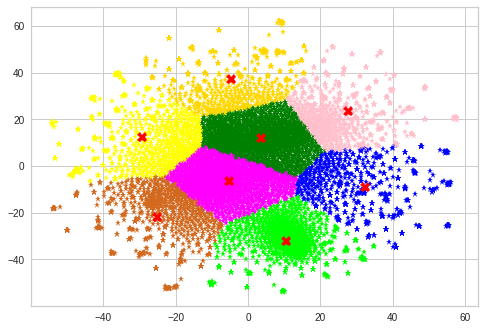

In [37]:
plot_clusters(X_tfidf_tsne, y_labels, kmeans_tsne.labels_, centroids=kmeans_tsne.cluster_centers_)

## PCA

In [38]:
X_tfidf_pca = pca.fit_transform(X_tfidf.todense())
kmeans_pca = KMeans(n_clusters=8, random_state=rs)
kmeans_pca.fit(X_tfidf_pca)
score_results(X_tfidf_pca, y_labels, kmeans_pca.labels_)

Adjusted Mutual Info Score 	-> 0.08344801062110127
Completeness Score 	-> 0.08559418604151472
homogeneity Score 	-> 0.08418985622219088
Silhouette Score-> 0.345576221232152


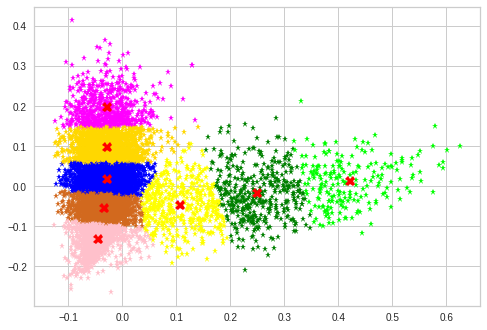

In [39]:
plot_clusters(X_tfidf_pca, y_labels, kmeans_pca.labels_, centroids=kmeans_pca.cluster_centers_)

## Kmeans 2_grams

In [78]:
X_tfidf_ngrams = tfidf_ngrams.fit_transform(X)
kmeans_ngrams = KMeans(n_clusters=8, random_state=rs)
kmeans_ngrams.fit(X_tfidf_ngrams)
score_results(X_tfidf_ngrams, y_labels, kmeans_ngrams.labels_)

Adjusted Mutual Info Score 	-> 0.17719277289316854
Completeness Score 	-> 0.18107931718803896
homogeneity Score 	-> 0.1768713458287997
Silhouette Score-> 0.0008238841330177537


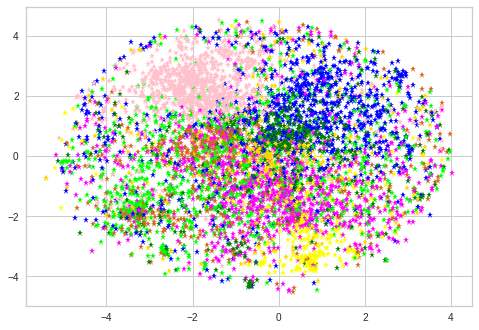

In [79]:
plot_clusters(X_tfidf_ngrams, kmeans_ngrams.labels_, y_labels, mode=TSNE)